In [5]:
import pandas as pd
import numpy as np
import os
import gc  # Garbage collection to free up RAM
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- CONFIGURATION ---
DATA_FOLDER = os.path.normpath(r'D:/IIT KHARAGPUR/Sem6/data_64Hz') 
WINDOW_SIZE = 1920 
OUTPUT_X = 'X_train_data.npy'
OUTPUT_Y = 'y_train_labels.npy'

def process_sleep_files(folder_path):
    all_windows = []
    all_labels = []
    
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    print(f"Starting processing {len(files)} files...")

    scaler = StandardScaler()
    global_labels = set()

    for filename in files:
        filepath = os.path.join(folder_path, filename)
        try:
            # Load only needed columns to save RAM
            df = pd.read_csv(filepath, usecols=['HR', 'Sleep_Stage'])
            
            global_labels.update(df['Sleep_Stage'].unique().tolist())
            df['HR_scaled'] = scaler.fit_transform(df[['HR']]).astype(np.float32)

            num_windows = len(df) // WINDOW_SIZE 
            
            for i in range(num_windows):
                start = i * WINDOW_SIZE
                window_hr = df['HR_scaled'].iloc[start : start + WINDOW_SIZE].values
                label = df['Sleep_Stage'].iloc[start : start + WINDOW_SIZE].mode()[0]
                
                all_windows.append(window_hr)
                all_labels.append(label)
            
            print(f"Processed: {filename}")
            
            # CRITICAL: Clear memory after each file
            del df
            gc.collect() 
        
        except Exception as e:
            print(f"Error in {filename}: {e}")

    print("Collating data into final arrays...")
    X = np.array(all_windows, dtype=np.float32)
    y_raw = np.array(all_labels)

    encoder = LabelEncoder()
    encoder.fit(list(global_labels))
    y = encoder.transform(y_raw)
    
    print(f"Mapping: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")

    # Final Reshape for CNN/LSTM (Samples, Time-steps, 1)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y

# --- EXECUTION ---
X, y = process_sleep_files(DATA_FOLDER)
if X is not None:
    np.save(OUTPUT_X, X)
    np.save(OUTPUT_Y, y)
    print(f"Done! Final Shape: {X.shape}")

Starting processing 100 files...
Processed: S002_whole_df.csv
Processed: S003_whole_df.csv
Processed: S004_whole_df.csv
Processed: S005_whole_df.csv
Processed: S006_whole_df.csv
Processed: S007_whole_df.csv
Processed: S008_whole_df.csv
Processed: S009_whole_df.csv
Processed: S010_whole_df.csv
Processed: S011_whole_df.csv
Processed: S012_whole_df.csv
Processed: S013_whole_df.csv
Processed: S014_whole_df.csv
Processed: S015_whole_df.csv
Processed: S016_whole_df.csv
Processed: S017_whole_df.csv
Processed: S018_whole_df.csv
Processed: S019_whole_df.csv
Processed: S020_whole_df.csv
Processed: S021_whole_df.csv
Processed: S022_whole_df.csv
Processed: S023_whole_df.csv
Processed: S024_whole_df.csv
Processed: S025_whole_df.csv
Processed: S026_whole_df.csv
Processed: S027_whole_df.csv
Processed: S028_whole_df.csv
Processed: S029_whole_df.csv
Processed: S030_whole_df.csv
Processed: S031_whole_df.csv
Processed: S032_whole_df.csv
Processed: S033_whole_df.csv
Processed: S034_whole_df.csv
Processed:

# traning code

d:\IIT KHARAGPUR\Sem6\IS Project\isp\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training started with balanced weights...
Epoch 1/15
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 332s 124ms/step - accuracy: 0.3221 - loss: 1.9136 - val_accuracy: 0.4301 - val_loss: 1.7831
Epoch 2/15
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 256s 77ms/step - accuracy: 0.3120 - loss: 1.8871 - val_accuracy: 0.2587 - val_loss: 1.8312
Epoch 3/15
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 142s 53ms/step - accuracy: 0.3361 - loss: 1.9054 - val_accuracy: 0.2117 - val_loss: 1.8375
Epoch 4/15
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 137s 52ms/step - accuracy: 0.3085 - loss: 1.8948 - val_accuracy: 0.3564 - val_loss: 1.7761
Epoch 5/15
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 140s 53ms/step - accuracy: 0.3023 - loss: 1.8958 - val_accuracy: 0.2847 - val_loss: 1.7872
Epoch 6/15
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 137s 52ms/step - accuracy: 0.3254 - loss: 1.9044 - val_accuracy: 0.1876 - val_loss: 1.8548
Epoch 7/15
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 138s 52ms/step - accuracy: 0.3032 - loss: 1.8836 - val_accuracy: 0.3805 - val_loss: 1.7519
Epoch 8/15
2649/2649 ━━━━━

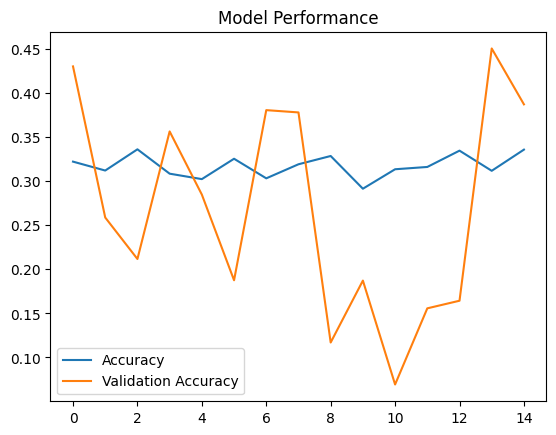

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. LOAD THE DATA
# Make sure these files exist in your current directory!
X = np.load('X_train_data.npy')
y = np.load('y_train_labels.npy')

# 2. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. BUILD MODEL
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(1920, 1)),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax') 
])

from sklearn.utils import class_weight

# 1. Calculate weights to handle the "N2 dominance"
# This tells the model: "Rare stages are more important!"
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(weights))

# 2. COMPILE
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. TRAIN with class_weight
print("Training started with balanced weights...")
history = model.fit(
    X_train, y_train, 
    epochs=15,            # Increased to 20 to give rare stages more time
    batch_size=32, 
    class_weight=class_weights_dict, # <--- KEY ADDITION
    validation_data=(X_test, y_test)
)
# 5. SAVE & VISUALIZE
model.save('sleep_model.h5')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()

# Prediction of sleep stages

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# 1. Load your trained brain
model = tf.keras.models.load_model('sleep_model.h5')

def predict_new_csv(file_path):
    # 2. Read the new file
    df = pd.read_csv(file_path)
    
    # 3. Normalize HR (Crucial! Use the same logic as training)
    scaler = StandardScaler()
    df['HR_scaled'] = scaler.fit_transform(df[['HR']])
    
    # 4. Create 30-second windows (1920 rows)
    WINDOW_SIZE = 1920
    windows = []
    num_windows = len(df) // WINDOW_SIZE
    
    for i in range(num_windows):
        start = i * WINDOW_SIZE
        window = df['HR_scaled'].iloc[start : start + WINDOW_SIZE].values
        windows.append(window)
    
    X_input = np.array(windows).reshape(-1, 1920, 1)
    
    # 5. Make Predictions
    predictions = model.predict(X_input)
    predicted_stages = np.argmax(predictions, axis=1)
    
    # Map numbers back to stage names (Adjust this to your specific mapping)
    # Example: 0: Wake, 1: N1, 2: N2, 3: REM
    stage_map = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'REM'}
    readable_stages = [stage_map[p] for p in predicted_stages]
    
    return readable_stages

# --- EXECUTION ---
# Change this to any new CSV file you have
new_file = 'D:/IIT KHARAGPUR/Sem6/data_64Hz/test_subject.csv'
results = predict_new_csv(new_file)
print(f"Predicted Stages for the night: {results}")

FileNotFoundError: [Errno 2] No such file or directory: 'D:/IIT KHARAGPUR/Sem6/data_64Hz/test_subject.csv'